### Grupo 24

Gabriel Antunes a101101
<br>
Guilherme Pinho a105533

<br>
Um sistema de tráfego é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e os arcos denotam vias de comunicação com apenas um sentido. O grafo tem de ser ligado: entre cada par de nodos <n1, n2> tem de existir um caminho n1 → n2 e um caminho n2 → n1.



1. Gerar aleatoriamente o grafo com  $$N \in\{6..10\}$$  nodos e com ramos verificando:

    i.  Cada nodo tem um número aleatório de descendentes $$d\in\{1 .. 3\}\,$$ cujos destinos são também gerados aleatoriamente. 
    
    ii. Se  existirem “loops” ou destinos repetidos, deve-se gerar outro grafo.
    
2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

Comecemos por inicilizar as varíaveis que vão definir o número de nodos do grafo principal e por construir esse mesmo grafo

In [17]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

[(6, 9), (6, 4), (6, 7), (5, 6), (9, 8), (9, 1), (4, 9), (2, 9), (2, 1), (7, 5), (7, 2), (3, 7), (3, 4), (3, 8), (8, 4), (1, 8), (1, 3), (1, 7)]


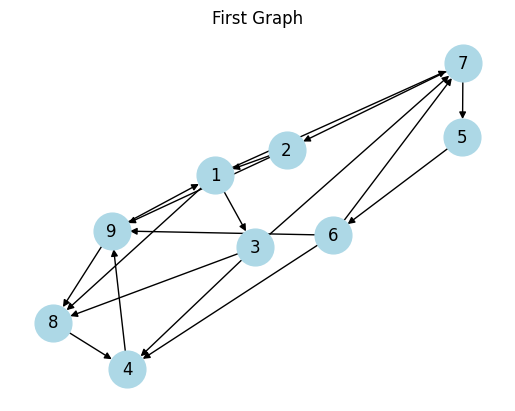

In [18]:
Num_Nodes = random.randint(6, 10)
List_Nodes = [n for n in range(1, Num_Nodes + 1)]

def verificar_conectividade(graph, start, end):
    return nx.has_path(graph, start, end) and nx.has_path(graph.reverse(), end, start)

def makeGraph():
    random.shuffle(List_Nodes)
    graph = nx.DiGraph()
    graph.add_nodes_from(List_Nodes)

    for n1 in range(Num_Nodes):
        List = List_Nodes.copy()
        List.remove(List_Nodes[n1])

        for _ in range(random.randint(1, 3)):
            if List:
                x = random.choice(List)
                if not graph.has_edge(List_Nodes[n1], x) and not graph.has_edge(x, List_Nodes[n1]):
                    graph.add_edge(List_Nodes[n1], x)
    return graph

grafico = makeGraph()

# Verificação de conectividade
for n in List_Nodes:
    for i in List_Nodes:
        if not verificar_conectividade(grafico, n, i):
            grafico = makeGraph()
            
print(grafico.edges())            

plt.title("First Graph")
nx.draw(grafico, with_labels=True, node_color='lightblue', node_size=700, arrows=True)
            


Agora vamos acrescentar os nodos que vão atuar como descendentes destes nodos já existentes

Agora em seguida vamos tentar retirar o maximo de arestas possiveis deixando o grafo ainda ligado

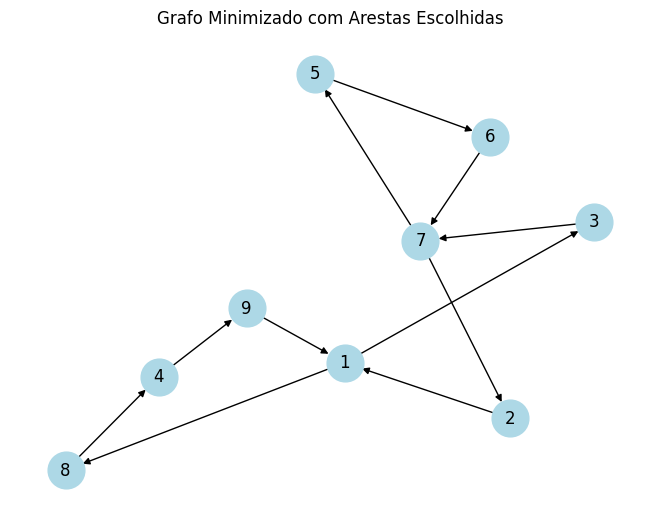

In [19]:
# Criar modelo SCIP
model = pywraplp.Solver.CreateSolver("SCIP")

# Adicionar variáveis para cada aresta
edge_vars = {}

for u, v in grafico.edges():
    edge_vars[(u, v)] = model.BoolVar(f"x_{u}_{v}")

nodes = [n for n in grafico.nodes()]
s = nodes.pop(0)

P = {}
# Restrições de Conectividade
for d in nodes:
       
    #garantir que ha caminho de s para d
    
    paths = list(nx.all_simple_edge_paths(grafico, s, d))
    N = len(paths)
    for i in range(N):
        P[(s,d,i)] = model.BoolVar('%i%i%i' %(s,d,i))
        for edge in paths[i]:
            model.Add(P[(s,d,i)] <= edge_vars[edge])
    model.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
    
    #garantir que ha caminho de d para s
    
    paths = list(nx.all_simple_edge_paths(grafico, d, s))
    N = len(paths)
    for i in range(N):
        P[(d,s,i)] = model.BoolVar('%i%i%i' %(d,s,i))
        for edge in paths[i]:
            model.Add(P[(d,s,i)] <= edge_vars[edge])
    model.Add(sum([P[(d,s,i)] for i in range(N)])>=1)

model.Minimize(sum(edge_vars.values()))

# Resolver o modelo
status = model.Solve()

# Verificar o status e imprimir resultados
if status == pywraplp.Solver.OPTIMAL:

    chosen_edges = [(u, v) for (u, v) in grafico.edges() if edge_vars[(u, v)].solution_value() == 1]
    if chosen_edges:
        subgraph = grafico.edge_subgraph(chosen_edges)
        nx.draw(subgraph, with_labels=True, node_color='lightblue', node_size=700, arrows=True)
        plt.title("Grafo Minimizado com Arestas Escolhidas")
        plt.show()
else:
    print("Sem solução")